# 1. Install Dependencies.

In [1]:
from IPython.display import clear_output

%pip install --quiet --upgrade diffusers transformers accelerate mediapy safetensors

clear_output()

# 2. Import Packages.

In [2]:
import numpy as np
from tqdm import tqdm
from PIL import Image

import torch
from torch import autocast
import requests

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import DPTForDepthEstimation, DPTFeatureExtractor

from diffusers import StableDiffusionPipeline, StableDiffusionInstructPix2PixPipeline
from diffusers import EulerAncestralDiscreteScheduler

# 3. Select Model.

In [9]:
device = "cuda"

pipe_gen = StableDiffusionPipeline.from_pretrained("SG161222/Realistic_Vision_V5.1_noVAE", torch_dtype=torch.float32)
pipe_gen.to(device)

model_id = "timbrooks/instruct-pix2pix"
pipe_edit = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe_edit.to("cuda")
pipe_edit.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe_edit.scheduler.config)

clear_output()

# 4. Generating.

  0%|          | 0/100 [00:00<?, ?it/s]

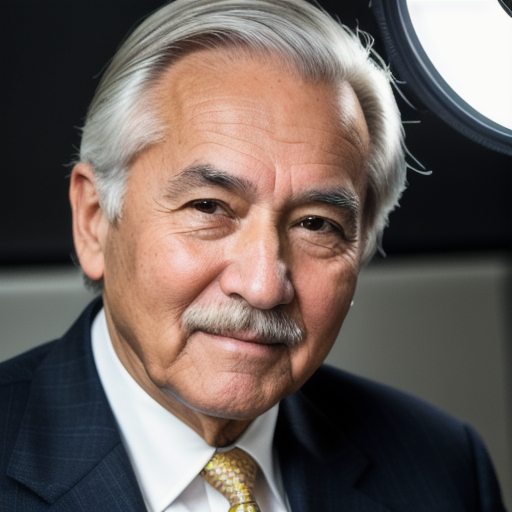

In [62]:
prompt = "old man in office" #@param
pre_prompt = "RAW Photo, "
extra_prompt = ", (high detailed skin:1.2), (high detailed hair:1.2), rim lighting, looking at the camera, studio lighting, dslr, ultra quality, sharp focus, tack sharp, dof, film grain, Fujifilm XT3, crystal clear, highly detailed glossy eyes, skin pores"
negative_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"

seed = np.random.randint(0, 2147483647)

torch.cuda.empty_cache()
generator = torch.Generator(device=device).manual_seed(seed)
image = pipe_gen(
             pre_prompt + prompt + extra_prompt,
             negative_prompt=negative_prompt,
             height=512, width=512,
             num_inference_steps=100,
             guidance_scale=7.5,
             generator=generator).images[0]

image

# 5. Editing

  0%|          | 0/100 [00:00<?, ?it/s]

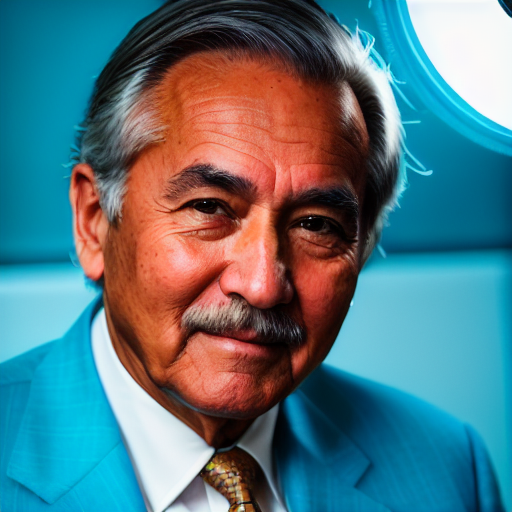

In [70]:
prompt = "change shirt color" #@param
pre_prompt = "RAW Photo, "
extra_prompt = ", save face brightness and color, rim lighting, looking at the camera, studio lighting, dslr, ultra quality, sharp focus, tack sharp, dof, film grain, Fujifilm XT3, crystal clear, (highly detailed glossy eyes:1.2), skin pores"
negative_prompt = "g&w, (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, extra heads, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
num_outputs = 1
num_inference_steps = 100
guidance_scale = 6.5
image_guidance_scale = 1.5
seed = np.random.randint(0, 2147483647)

images = pipe_edit(
      prompt=pre_prompt+prompt+extra_prompt,
      negative_prompt=negative_prompt,
      image=image,
      num_inference_steps=num_inference_steps,
      image_guidance_scale=image_guidance_scale,
      height=512, width=512,
      num_outputs=num_outputs).images

images[0]